<a href="https://colab.research.google.com/github/owaikien/LSTM-bitcoin-prediction/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
np.random.seed(42)
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from datetime import date, timedelta, datetime
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from keras.layers import CuDNNLSTM
from keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8


In [3]:
!pip install cryptocompare

  Preparing metadata (setup.py) ... done
  Created wheel for cryptocompare: filename=cryptocompare-0.7.6-py3-none-any.whl size=6290 sha256=7d8cb859a903edf6b5c8b1d4675c6374d690f3237e75223d4e594f85a095ef28
  Stored in directory: /root/.cache/pip/wheels/97/81/6a/261bc499b9d9bf8b391eea52c90a4746b477539564b0a66c94
Successfully built cryptocompare


# Importing Data

#### Price Data

In [4]:
sns.set_style('white', {'axes.spines.right':True, 'axes.spines.top':False})
import cryptocompare as cc
import requests
import IPython
import yaml
import json

# Remember to import your API key into current Google Colab directory
# Set the API key from yaml file
yaml_file = open("sample_data/chain_api.yml")
p = yaml.load(yaml_file, Loader=yaml.FullLoader)
api_key = p['api_key']

# Number of days we retrieve data
data_limit = 2000

# Define pairs
fysm = 'BTC'
tysm = 'USD'

# Query data
def api_call(url):
    # Set API key as Header
    headers = {'authorization':'Apikey' + api_key,}
    session = requests.Session()
    session.headers.update(headers)

    # API call to cryptocompare
    response = session.get(url)

    # Conversion of the response to dataframe
    historic_blockdata_dict = json.loads(response.text)
    df = pd.DataFrame.from_dict(historic_blockdata_dict['Data']['Data'], orient='columns', dtype=None, columns=None)

    return df

def call_all():
    dfs = []
    # 1st call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}')
    dfs.append(df)
    # defining the latest time point for the next call
    latest = df['time'][0]

    # 2nd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    dfs.append(df)
    latest = df['time'][0]

    # 3rd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    dfs.append(df)

    dfs = pd.concat(dfs, ignore_index=True)
    dfs['date'] = pd.to_datetime(dfs['time'], unit='s')

    return dfs

# sort df by date, drop values with 0 and unnecessary columns, drop duplicates row and reset index
base_url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym='
btcprice = call_all()
btcprice.sort_values(by='date', inplace=True)
btcprice = btcprice.loc[~(btcprice['close']==0)]
btcprice.drop(columns=['time', 'conversionType', 'conversionSymbol', 'high', 'low', 'open', 'volumefrom', 'volumeto'], inplace=True)
btcprice = btcprice.drop_duplicates(subset='date', keep='first')
btcprice = btcprice.reset_index(drop=True)
btcprice


<ipython-input-4-8f431c387fd4>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btcprice.drop(columns=['time', 'conversionType', 'conversionSymbol', 'high', 'low', 'open', 'volumefrom', 'volumeto'], inplace=True)


,close,date
0,0.04951,2010-07-17
1,0.08584,2010-07-18
2,0.08080,2010-07-19
3,0.07474,2010-07-20
4,0.07921,2010-07-21
...,...,...
4724,30700.29000,2023-06-23
4725,30548.03000,2023-06-24
4726,30473.33000,2023-06-25
4727,30274.61000,2023-06-26


### Volume Data

In [5]:
# Volume dataframe
# Query data
def api_call(url):
    # Set API key as Header
    headers = {'authorization':'Apikey' + api_key,}
    session = requests.Session()
    session.headers.update(headers)

    # API call to cryptocompare
    response = session.get(url)

    # Conversion of the response to dataframe
    historic_blockdata_dict = json.loads(response.text)
    df = pd.DataFrame.from_dict(historic_blockdata_dict['Data'], orient='columns', dtype=None, columns=None)

    return df

def call_all():
    dfs = []
    # 1st call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}')
    dfs.append(df)
    # defining the latest time point for the next call
    latest = df['time'][0]

    # 2nd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    dfs.append(df)
    latest = df['time'][0]

    # 3rd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    dfs.append(df)

    dfs = pd.concat(dfs, ignore_index=True)
    dfs['date'] = pd.to_datetime(dfs['time'], unit='s')

    return dfs

base_url = 'https://min-api.cryptocompare.com/data/exchange/histoday?fsym='
volume = call_all()
volume.sort_values(by='date', inplace=True)
volume = volume.loc[~(volume['volume']==0)]
volume.drop(columns=['time'], inplace=True)
volume = volume.drop_duplicates(subset='date', keep='first')
volume = volume.reset_index(drop=True)
volume



,volume,date
0,1.471840e+03,2013-03-11
1,1.796934e+04,2013-03-12
2,1.148273e+04,2013-03-13
3,1.269439e+04,2013-03-14
4,2.271394e+04,2013-03-15
...,...,...
3756,1.606676e+10,2023-06-23
3757,9.512074e+09,2023-06-24
3758,9.615098e+09,2023-06-25
3759,1.264795e+10,2023-06-26


### Onchain Data

In [6]:
# Generic function for an API call to a given URL
def api_call(url):
  # Set API Key as Header
  headers = {'authorization': 'Apikey ' + api_key,}
  session = requests.Session()
  session.headers.update(headers)

  # API call to cryptocompare
  response = session.get(url)

  # Conversion of the response to dataframe
  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  return df

# Prepare the onchain dataframe
def call_all():
    dfs = []
    # 1st call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}')
    df = df[df['hashrate'] > 0.0]
    dfs.append(df)
    latest = df['time'][0]

    # 2nd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    df = df[df['hashrate'] > 0.0]
    dfs.append(df)
    latest = df['time'][0]

    # 3rd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    df = df[df['hashrate'] > 0.0]
    dfs.append(df)

    dfs = pd.concat(dfs, ignore_index=True)
    dfs['date'] = pd.to_datetime(dfs['time'], unit='s')

    return dfs

# Load onchain data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym='
onchain = call_all()
# sort df by date from oldest to newest
onchain.sort_values(by='date', inplace=True, ascending=True)
onchain.drop(columns=['unique_addresses_all_time','id', 'symbol', 'time', 'block_height',
                      'average_transaction_value', 'block_time', 'block_size', 'current_supply', 'transaction_count'], inplace=True)
onchain = onchain.drop_duplicates(subset='date', keep='first')
onchain = onchain.reset_index(drop=True)
# latest day on chain data is unavailable
onchain

,zero_balance_addresses_all_time,new_addresses,active_addresses,transaction_count_all_time,large_transaction_count,hashrate,difficulty,date
0,0,14,14,15,0,9.425148e-06,1.000000e+00,2009-01-09
1,0,61,61,76,0,3.730645e-06,1.000000e+00,2009-01-10
2,0,93,93,169,0,4.669160e-06,1.000000e+00,2009-01-11
3,2,101,102,270,0,5.440074e-06,1.000000e+00,2009-01-12
4,2,123,123,393,0,6.124981e-06,1.000000e+00,2009-01-13
...,...,...,...,...,...,...,...,...
5273,1118957290,481230,1008212,855405207,18076,3.687291e+08,5.235044e+13,2023-06-22
5274,1119374639,464468,951874,855779208,17772,3.265891e+08,5.235044e+13,2023-06-23
5275,1119924522,472545,1013179,856140645,13610,3.805523e+08,5.235044e+13,2023-06-24
5276,1120448883,467323,951595,856523414,11706,4.011621e+08,5.235044e+13,2023-06-25


### Coin Distribution Data

In [7]:
# retrieving number of bitcoin distributed among the stakeholders
# separate API (data/blockchain/balancedistribution/histo)
# Prepare balance distribution dataframe
def prepare_balancedistribution_data(df):
  df['balance_distribution'] = df['balance_distribution'].apply(lambda x: [i for i in x])
  json_struct = json.loads(df[['time','balance_distribution']].to_json(orient="records"))
  df_ = pd.json_normalize(json_struct)
  df_['date'] = pd.to_datetime(df_['time'], unit='s')
  df_flat = pd.concat([df_.explode('balance_distribution').drop(['balance_distribution'], axis=1),
           df_.explode('balance_distribution')['balance_distribution'].apply(pd.Series)], axis=1)
  df_flat.reset_index(drop=True, inplace=True)
  df_flat['range'] = ['' + str(float(df_flat['from'][x])) + '_to_' + str(float(df_flat['to'][x])) for x in range(df_flat.shape[0])]
  df_flat.drop(columns=['from','to'], inplace=True)

  # Data cleansing
  df_flat = df_flat[~df_flat['range'].isin(['100000.0_to_0.0'])]
  df_flat['range'].iloc[df_flat['range'] == '1e-08_to_0.001'] = '0.0_to_0.001'
  return df_flat

def call_all():
    dfs = []
    # 1st call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}')
    df = prepare_balancedistribution_data(df)
    dfs.append(df)
    latest = df['time'][0]

    # 2nd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    df = prepare_balancedistribution_data(df)
    dfs.append(df)
    latest = df['time'][0]

    # 3rd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    df = prepare_balancedistribution_data(df)
    dfs.append(df)

    dfs = pd.concat(dfs, ignore_index=True)
    #dfs['date'] = pd.to_datetime(dfs['time'], unit='s')

    return dfs

# Load the balance distribution data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym='
distribution = call_all()
distribution.drop(columns=['time'], inplace=True)
distribution = distribution.sort_values(by='date', ascending=True)
distribution.reset_index(drop=True, inplace=True)
distribution

,date,totalVolume,addressesCount,range
0,2009-01-03,0.000000e+00,0.0,0.0_to_0.001
1,2009-01-03,0.000000e+00,0.0,0.001_to_0.01
2,2009-01-03,0.000000e+00,0.0,0.01_to_0.1
3,2009-01-03,0.000000e+00,0.0,0.1_to_1.0
4,2009-01-03,0.000000e+00,0.0,1.0_to_10.0
...,...,...,...,...
48165,2023-06-26,1.052086e+06,3386641.0,0.1_to_1.0
48166,2023-06-26,2.117221e+06,848817.0,1.0_to_10.0
48167,2023-06-26,4.442249e+06,140387.0,10.0_to_100.0
48168,2023-06-26,3.887893e+06,13849.0,100.0_to_1000.0


In [8]:
df_distr = distribution.copy()
df_distr.reset_index(drop=True, inplace=True)
df_distr = df_distr.pivot_table(values='addressesCount', index='date', columns='range')
df_distr.fillna(method='ffill', inplace=True)
distr = df_distr[['1000.0_to_10000.0', '10000.0_to_100000.0']]
distr

range,1000.0_to_10000.0,10000.0_to_100000.0
date,,
2009-01-03,0.0,0.0
2009-01-04,0.0,0.0
2009-01-05,0.0,0.0
2009-01-06,0.0,0.0
2009-01-07,0.0,0.0
...,...,...
2023-06-22,1928.0,107.0
2023-06-23,1929.0,106.0
2023-06-24,1927.0,106.0


### Merge all data

In [9]:
final = btcprice.merge(onchain, on='date', how='left').merge(distr, on='date', how='left').merge(volume, on='date', how='left')
final['yesterday'] = final['close'].shift(1)
final.fillna(method='ffill', inplace=True)
final.fillna(method='backfill', inplace=True)
final.head()

,close,date,zero_balance_addresses_all_time,new_addresses,active_addresses,transaction_count_all_time,large_transaction_count,hashrate,difficulty,1000.0_to_10000.0,10000.0_to_100000.0,volume,yesterday
0,0.04951,2010-07-17,34727.0,447.0,804.0,87062.0,0.0,0.001588,181.543289,9.0,0.0,1471.84,0.04951
1,0.08584,2010-07-18,35257.0,467.0,917.0,87482.0,0.0,0.001625,181.543289,21.0,2.0,1471.84,0.04951
2,0.08080,2010-07-19,35744.0,605.0,972.0,88010.0,0.0,0.001578,181.543289,29.0,4.0,1471.84,0.08584
3,0.07474,2010-07-20,36257.0,674.0,906.0,88604.0,0.0,0.001634,181.543289,32.0,5.0,1471.84,0.08080
4,0.07921,2010-07-21,36679.0,469.0,809.0,89067.0,0.0,0.001866,181.543289,33.0,7.0,1471.84,0.07474


### Feature Engineering

In [10]:
# Calculate day-to-day diff in price
final['price_diff'] = final['close'].diff()

# Calculate percentage change in price
final['price_pct_change'] = final['close'].pct_change()

# Time-based features
# day of week
final['day_of_week'] = final['date'].dt.dayofweek

# month
final['month'] = final['date'].dt.month

# year
final['year'] = final['date'].dt.year

In [11]:
# remove first row
final = final.tail(-1).reset_index(drop=True)
final

,close,date,zero_balance_addresses_all_time,new_addresses,active_addresses,transaction_count_all_time,large_transaction_count,hashrate,difficulty,1000.0_to_10000.0,10000.0_to_100000.0,volume,yesterday,price_diff,price_pct_change,day_of_week,month,year
0,0.08584,2010-07-18,3.525700e+04,467.0,917.0,87482.0,0.0,1.624739e-03,1.815433e+02,21.0,2.0,1.471840e+03,0.04951,0.03633,0.733791,6,7,2010
1,0.08080,2010-07-19,3.574400e+04,605.0,972.0,88010.0,0.0,1.577979e-03,1.815433e+02,29.0,4.0,1.471840e+03,0.08584,-0.00504,-0.058714,0,7,2010
2,0.07474,2010-07-20,3.625700e+04,674.0,906.0,88604.0,0.0,1.633687e-03,1.815433e+02,32.0,5.0,1.471840e+03,0.08080,-0.00606,-0.075000,1,7,2010
3,0.07921,2010-07-21,3.667900e+04,469.0,809.0,89067.0,0.0,1.865885e-03,1.815433e+02,33.0,7.0,1.471840e+03,0.07474,0.00447,0.059807,2,7,2010
4,0.05050,2010-07-22,3.691400e+04,434.0,599.0,89464.0,0.0,1.600097e-03,1.815433e+02,38.0,7.0,1.471840e+03,0.07921,-0.02871,-0.362454,3,7,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723,30700.29000,2023-06-23,1.119375e+09,464468.0,951874.0,855779208.0,17772.0,3.265891e+08,5.235044e+13,1929.0,106.0,1.606676e+10,29893.34000,806.95000,0.026994,4,6,2023
4724,30548.03000,2023-06-24,1.119925e+09,472545.0,1013179.0,856140645.0,13610.0,3.805523e+08,5.235044e+13,1927.0,106.0,9.512074e+09,30700.29000,-152.26000,-0.004960,5,6,2023
4725,30473.33000,2023-06-25,1.120449e+09,467323.0,951595.0,856523414.0,11706.0,4.011621e+08,5.235044e+13,1923.0,106.0,9.615098e+09,30548.03000,-74.70000,-0.002445,6,6,2023
4726,30274.61000,2023-06-26,1.120970e+09,471563.0,1010313.0,856927393.0,15596.0,3.774025e+08,5.235044e+13,1930.0,105.0,1.264795e+10,30473.33000,-198.72000,-0.006521,0,6,2023


In [12]:
# Change variables from int64 to float64
final['day_of_week'] = final['day_of_week'].astype('float64')
final['month'] = final['month'].astype('float64')
final['year'] = final['year'].astype('float64')

In [13]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4728 entries, 0 to 4727
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   close                            4728 non-null   float64       
 1   date                             4728 non-null   datetime64[ns]
 2   zero_balance_addresses_all_time  4728 non-null   float64       
 3   new_addresses                    4728 non-null   float64       
 4   active_addresses                 4728 non-null   float64       
 5   transaction_count_all_time       4728 non-null   float64       
 6   large_transaction_count          4728 non-null   float64       
 7   hashrate                         4728 non-null   float64       
 8   difficulty                       4728 non-null   float64       
 9   1000.0_to_10000.0                4728 non-null   float64       
 10  10000.0_to_100000.0              4728 non-null   float64    

### Pearson Correlation

<ipython-input-14-e943f4ac5b36>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(final.corr())
<ipython-input-14-e943f4ac5b36>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(final.corr(), mask=mask, linewidths=1.5, vmax=1.0,


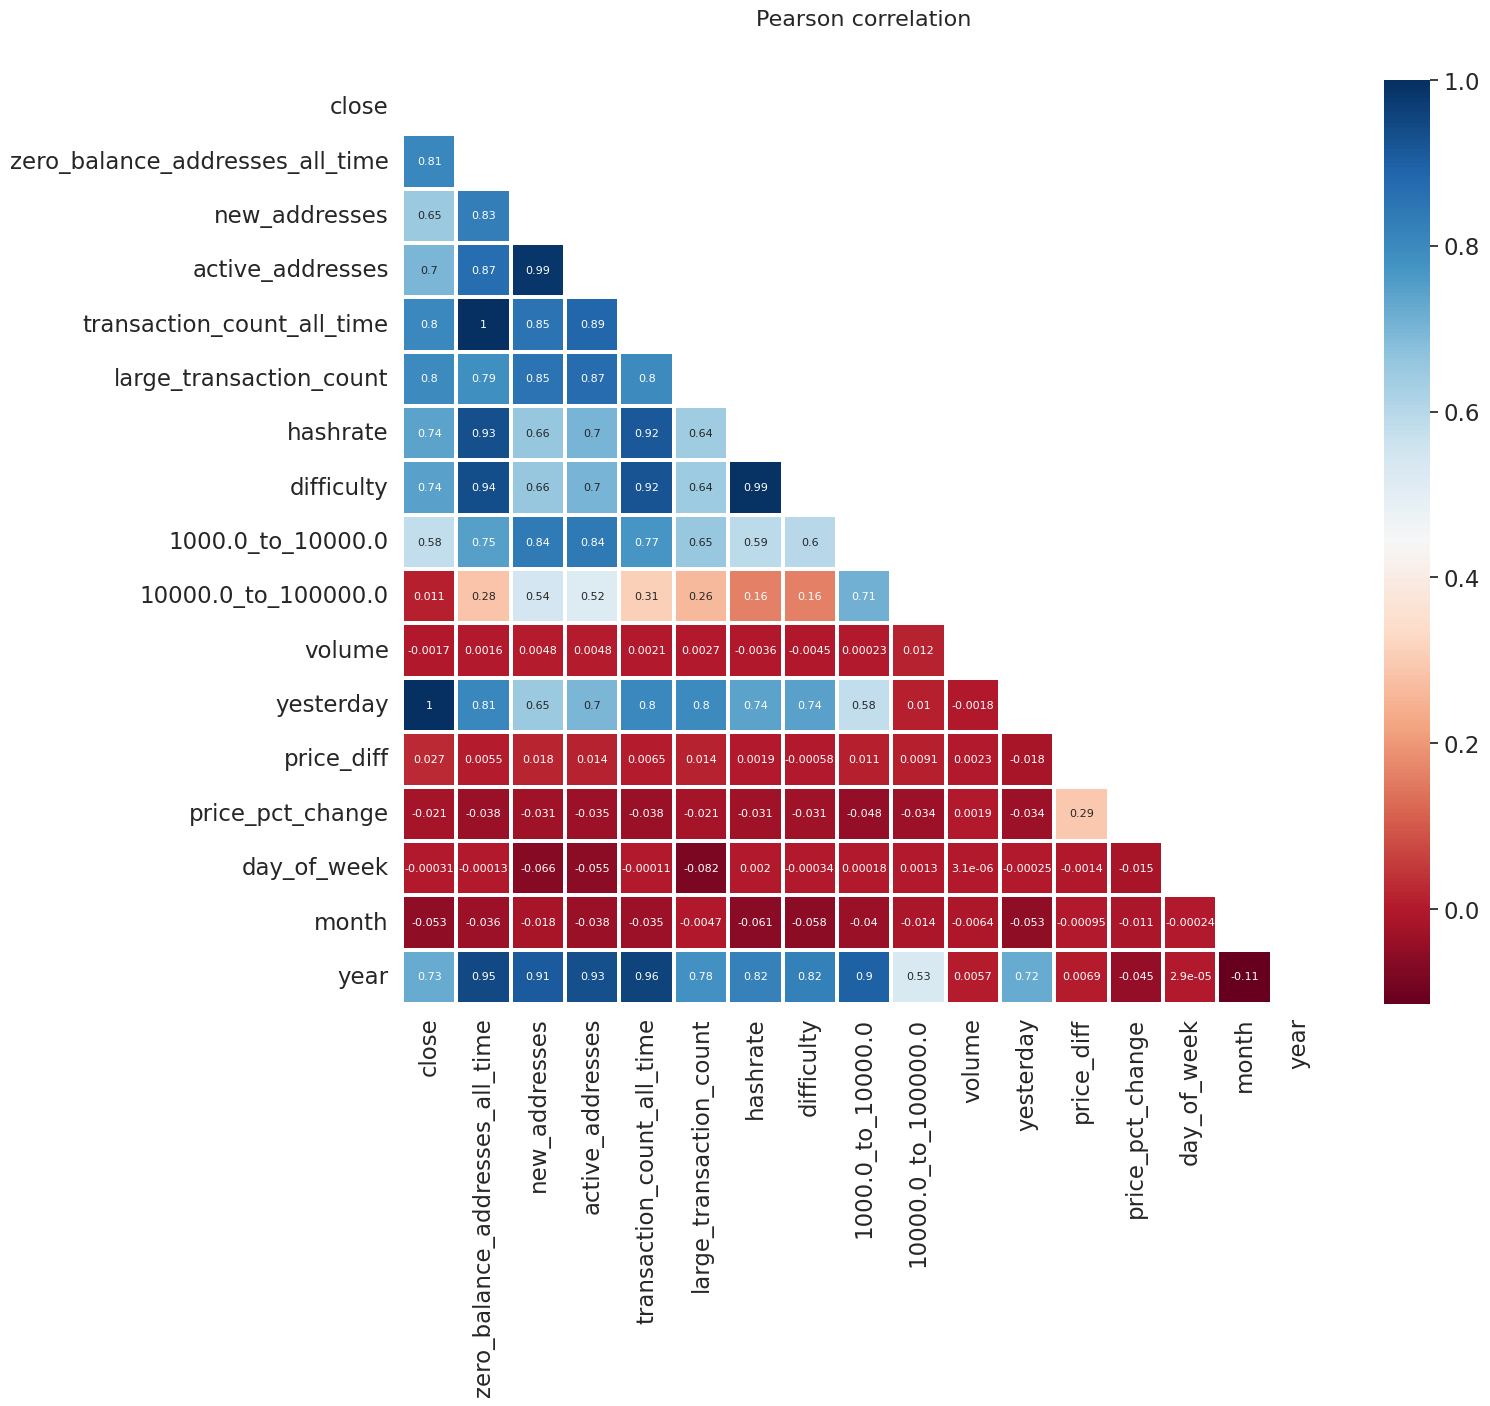

In [14]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15, 12))
plt.title("Pearson correlation", y=1.05, size=16)

mask = np.zeros_like(final.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(final.corr(), mask=mask, linewidths=1.5, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"fontsize":8})
plt.show()

In [15]:
final.columns

Index(['close', 'date', 'zero_balance_addresses_all_time', 'new_addresses',
       'active_addresses', 'transaction_count_all_time',
       'large_transaction_count', 'hashrate', 'difficulty',
       '1000.0_to_10000.0', '10000.0_to_100000.0', 'volume', 'yesterday',
       'price_diff', 'price_pct_change', 'day_of_week', 'month', 'year'],
      dtype='object')

### Prepare final data

In [16]:
df = final.copy()
df.head()

,close,date,zero_balance_addresses_all_time,new_addresses,active_addresses,transaction_count_all_time,large_transaction_count,hashrate,difficulty,1000.0_to_10000.0,10000.0_to_100000.0,volume,yesterday,price_diff,price_pct_change,day_of_week,month,year
0,0.08584,2010-07-18,35257.0,467.0,917.0,87482.0,0.0,0.001625,181.543289,21.0,2.0,1471.84,0.04951,0.03633,0.733791,6.0,7.0,2010.0
1,0.08080,2010-07-19,35744.0,605.0,972.0,88010.0,0.0,0.001578,181.543289,29.0,4.0,1471.84,0.08584,-0.00504,-0.058714,0.0,7.0,2010.0
2,0.07474,2010-07-20,36257.0,674.0,906.0,88604.0,0.0,0.001634,181.543289,32.0,5.0,1471.84,0.08080,-0.00606,-0.075000,1.0,7.0,2010.0
3,0.07921,2010-07-21,36679.0,469.0,809.0,89067.0,0.0,0.001866,181.543289,33.0,7.0,1471.84,0.07474,0.00447,0.059807,2.0,7.0,2010.0
4,0.05050,2010-07-22,36914.0,434.0,599.0,89464.0,0.0,0.001600,181.543289,38.0,7.0,1471.84,0.07921,-0.02871,-0.362454,3.0,7.0,2010.0


In [17]:
df.columns = df.columns.str.title()
df.head()

,Close,Date,Zero_Balance_Addresses_All_Time,New_Addresses,Active_Addresses,Transaction_Count_All_Time,Large_Transaction_Count,Hashrate,Difficulty,1000.0_To_10000.0,10000.0_To_100000.0,Volume,Yesterday,Price_Diff,Price_Pct_Change,Day_Of_Week,Month,Year
0,0.08584,2010-07-18,35257.0,467.0,917.0,87482.0,0.0,0.001625,181.543289,21.0,2.0,1471.84,0.04951,0.03633,0.733791,6.0,7.0,2010.0
1,0.08080,2010-07-19,35744.0,605.0,972.0,88010.0,0.0,0.001578,181.543289,29.0,4.0,1471.84,0.08584,-0.00504,-0.058714,0.0,7.0,2010.0
2,0.07474,2010-07-20,36257.0,674.0,906.0,88604.0,0.0,0.001634,181.543289,32.0,5.0,1471.84,0.08080,-0.00606,-0.075000,1.0,7.0,2010.0
3,0.07921,2010-07-21,36679.0,469.0,809.0,89067.0,0.0,0.001866,181.543289,33.0,7.0,1471.84,0.07474,0.00447,0.059807,2.0,7.0,2010.0
4,0.05050,2010-07-22,36914.0,434.0,599.0,89464.0,0.0,0.001600,181.543289,38.0,7.0,1471.84,0.07921,-0.02871,-0.362454,3.0,7.0,2010.0


In [18]:
# Move Date to the first column
date = df.pop('Date')
close = df.pop('Close')

df.insert(0, 'Date', date)
df.insert(17, 'Close', close)
df

,Date,Zero_Balance_Addresses_All_Time,New_Addresses,Active_Addresses,Transaction_Count_All_Time,Large_Transaction_Count,Hashrate,Difficulty,1000.0_To_10000.0,10000.0_To_100000.0,Volume,Yesterday,Price_Diff,Price_Pct_Change,Day_Of_Week,Month,Year,Close
0,2010-07-18,3.525700e+04,467.0,917.0,87482.0,0.0,1.624739e-03,1.815433e+02,21.0,2.0,1.471840e+03,0.04951,0.03633,0.733791,6.0,7.0,2010.0,0.08584
1,2010-07-19,3.574400e+04,605.0,972.0,88010.0,0.0,1.577979e-03,1.815433e+02,29.0,4.0,1.471840e+03,0.08584,-0.00504,-0.058714,0.0,7.0,2010.0,0.08080
2,2010-07-20,3.625700e+04,674.0,906.0,88604.0,0.0,1.633687e-03,1.815433e+02,32.0,5.0,1.471840e+03,0.08080,-0.00606,-0.075000,1.0,7.0,2010.0,0.07474
3,2010-07-21,3.667900e+04,469.0,809.0,89067.0,0.0,1.865885e-03,1.815433e+02,33.0,7.0,1.471840e+03,0.07474,0.00447,0.059807,2.0,7.0,2010.0,0.07921
4,2010-07-22,3.691400e+04,434.0,599.0,89464.0,0.0,1.600097e-03,1.815433e+02,38.0,7.0,1.471840e+03,0.07921,-0.02871,-0.362454,3.0,7.0,2010.0,0.05050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723,2023-06-23,1.119375e+09,464468.0,951874.0,855779208.0,17772.0,3.265891e+08,5.235044e+13,1929.0,106.0,1.606676e+10,29893.34000,806.95000,0.026994,4.0,6.0,2023.0,30700.29000
4724,2023-06-24,1.119925e+09,472545.0,1013179.0,856140645.0,13610.0,3.805523e+08,5.235044e+13,1927.0,106.0,9.512074e+09,30700.29000,-152.26000,-0.004960,5.0,6.0,2023.0,30548.03000
4725,2023-06-25,1.120449e+09,467323.0,951595.0,856523414.0,11706.0,4.011621e+08,5.235044e+13,1923.0,106.0,9.615098e+09,30548.03000,-74.70000,-0.002445,6.0,6.0,2023.0,30473.33000
4726,2023-06-26,1.120970e+09,471563.0,1010313.0,856927393.0,15596.0,3.774025e+08,5.235044e+13,1930.0,105.0,1.264795e+10,30473.33000,-198.72000,-0.006521,0.0,6.0,2023.0,30274.61000


Text(0, 0.5, 'Close Price (USD)')

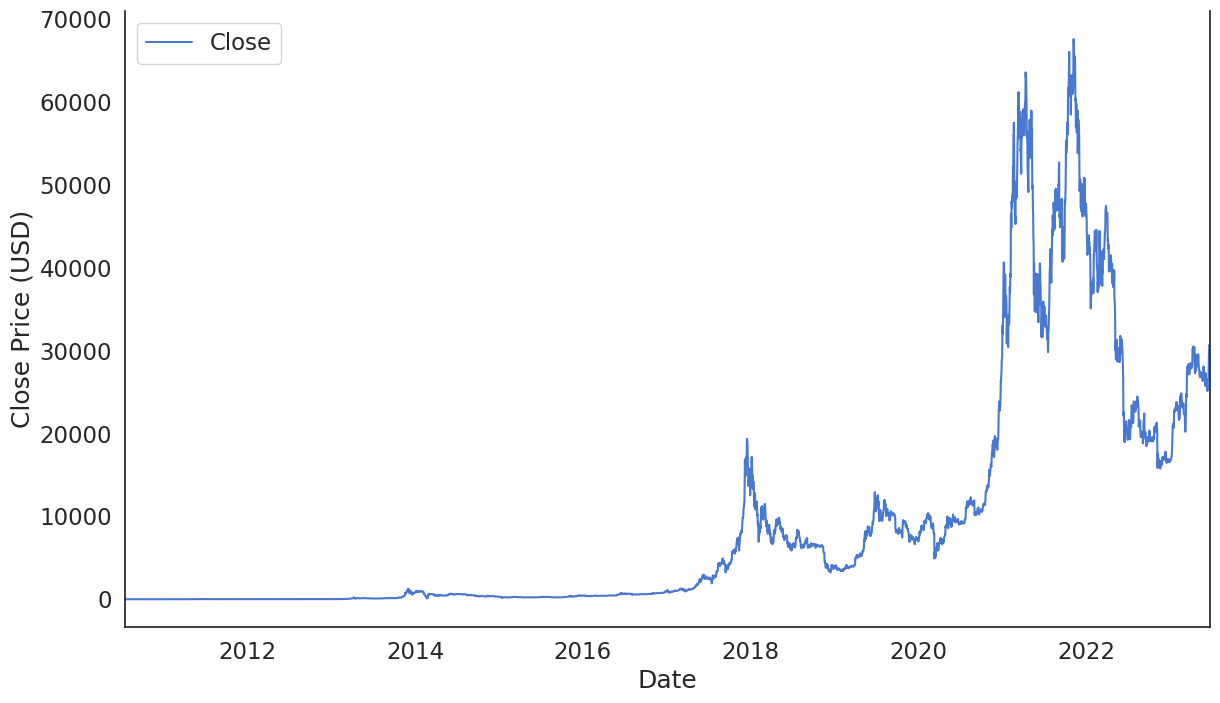

In [19]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

### Split and scale data

In [20]:
scaler = MinMaxScaler()

# skipping first column (date)
train_features = df.iloc[:int(len(df)*0.85), 1:].values.reshape(-1, 17)
test_features = df.iloc[int(len(df)*0.85):, 1:].values.reshape(-1, 17)

scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

In [21]:
scaled_train_features.shape

(4018, 17)

In [22]:
scaled_test_features.shape

(710, 17)

In [23]:
np.isnan(scaled_train_features).any()

False

In [24]:
np.isnan(scaled_test_features).any()

False

### Prepare sequential data

In [25]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(train_features, test_features, seq_len):

    train = to_sequences(train_features, seq_len)
    # X_trainc and X_test is a tensor
    # with shape (n_sequences, seq_len-1, num_features)
    # y_train is a tensor
    # with shape (num_sequences, 1)
    X_train = train[:, :-1, :]
    y_train = train[:, -1, -1].reshape(-1, 1)

    test = to_sequences(test_features, seq_len)
    X_test = test[:, :-1, :]
    y_test = test[:, -1, -1].reshape(-1, 1)

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_train_features, scaled_test_features, SEQ_LEN)

In [26]:
print(X_train.shape, y_train.shape)

(3918, 99, 17) (3918, 1)


In [27]:
print(X_test.shape, y_test.shape)

(610, 99, 17) (610, 1)


### Build model

In [28]:
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()
model.add(LSTM(100, input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dense(1))

### Train model

In [29]:
# compile
model.compile(
    loss='mae',
    optimizer='adam',
)

In [30]:
# model fitting
BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1,
    verbose=2
)

Epoch 1/100
56/56 - 9s - loss: 0.0517 - val_loss: 0.2479 - 9s/epoch - 156ms/step
Epoch 2/100
56/56 - 1s - loss: 0.0329 - val_loss: 0.2037 - 568ms/epoch - 10ms/step
Epoch 3/100
56/56 - 1s - loss: 0.0461 - val_loss: 0.2553 - 567ms/epoch - 10ms/step
Epoch 4/100
56/56 - 1s - loss: 0.0370 - val_loss: 0.2323 - 581ms/epoch - 10ms/step
Epoch 5/100
56/56 - 0s - loss: 0.0187 - val_loss: 0.1932 - 411ms/epoch - 7ms/step
Epoch 6/100
56/56 - 0s - loss: 0.0141 - val_loss: 0.1523 - 434ms/epoch - 8ms/step
Epoch 7/100
56/56 - 0s - loss: 0.0118 - val_loss: 0.1592 - 379ms/epoch - 7ms/step
Epoch 8/100
56/56 - 0s - loss: 0.0145 - val_loss: 0.1352 - 433ms/epoch - 8ms/step
Epoch 9/100
56/56 - 0s - loss: 0.0269 - val_loss: 0.1385 - 397ms/epoch - 7ms/step
Epoch 10/100
56/56 - 0s - loss: 0.0106 - val_loss: 0.1297 - 394ms/epoch - 7ms/step
Epoch 11/100
56/56 - 0s - loss: 0.0101 - val_loss: 0.1289 - 392ms/epoch - 7ms/step
Epoch 12/100
56/56 - 0s - loss: 0.0193 - val_loss: 0.1194 - 396ms/epoch - 7ms/step
Epoch 13/10

In [31]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 5ms/step - loss: 0.0339


0.033949896693229675

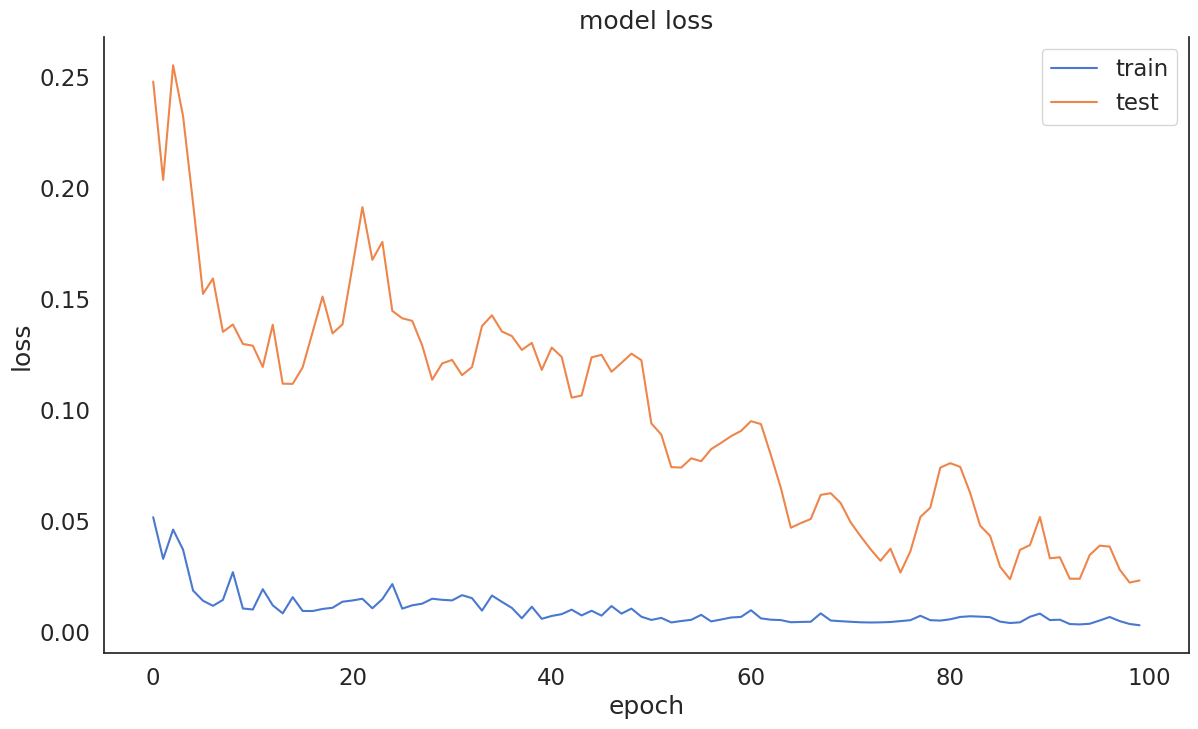

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Predict

In [33]:
y_hat = model.predict(X_test)

y_test_reshaped = np.zeros_like(scaled_test_features[:, -1:])
y_test_reshaped[-y_test.shape[0]:, :] = y_test.reshape(-1, 1)

y_hat_reshaped = np.zeros_like(scaled_test_features[:, -1:])
y_hat_reshaped[-y_hat.shape[0]:, :] = y_hat.reshape(-1, 1)

# inverse transform y_test and y_hat
y_test_inverse = scaler.inverse_transform(np.concatenate((scaled_test_features[:, :-1], y_test_reshaped), axis=1))[:, -1]
y_hat_inverse = scaler.inverse_transform(np.concatenate((scaled_test_features[:, :-1], y_hat_reshaped), axis=1))[:, -1]

20/20 [==============================] - 1s 7ms/step


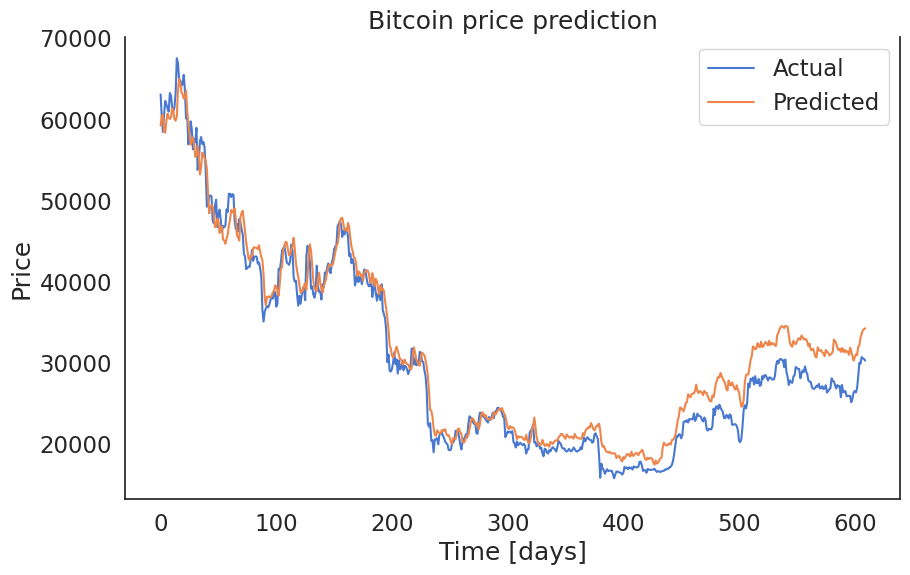

In [34]:
# visualize
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse[(len(y_test_inverse)-y_test.shape[0]):], label='Actual')
plt.plot(y_hat_inverse[(len(y_hat_inverse)-y_test.shape[0]):], label='Predicted')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show()

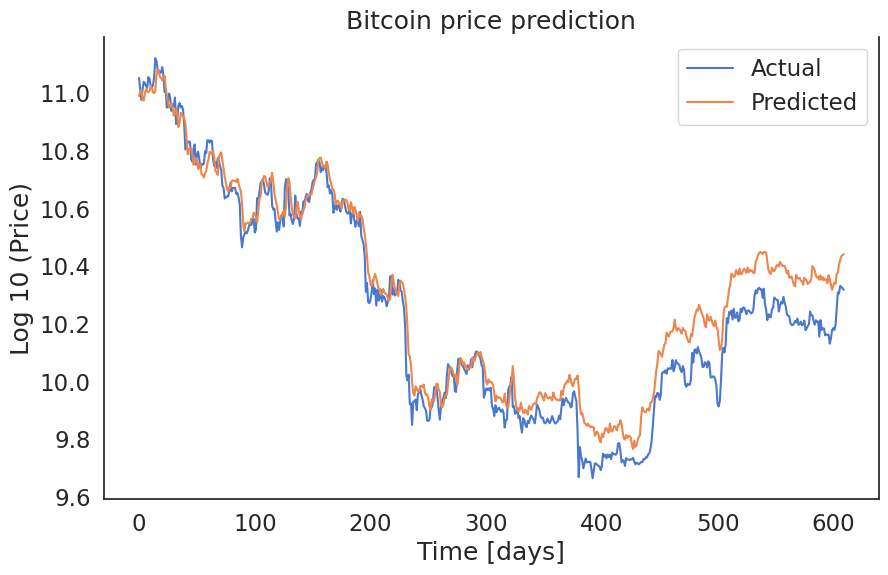

In [35]:
# log version
plt.figure(figsize=(10, 6))
plt.plot(np.log(y_test_inverse[(len(y_test_inverse)-y_test.shape[0]):]), label='Actual')
plt.plot(np.log(y_hat_inverse[(len(y_hat_inverse)-y_test.shape[0]):]), label='Predicted')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Log 10 (Price)')
plt.legend(loc='best')

plt.show()

## Backtesting

Let's try to use the model to trade in a stimulation, and since all the predicted price were lower than the actual price, we will use it to predict the direction of the price change.

In this case, we will use relative price change in within the model itself instead of comparing absolute values between the predicted price and the actual price.

In [37]:
portfolio_value = 10000  # Starting portfolio value
n_shares = 0  # Starting number of shares

portfolio_values = []  # To keep track of portfolio value over time

# Assume we have the predicted prices in a list y_hat
for i in range(len(y_hat) - 1):
    if y_hat[i+1] > y_hat[i]:  # Predicted price increase
        n_shares += portfolio_value / y_test[i]
        portfolio_value = 0
    elif y_hat[i+1] < y_hat[i] and n_shares > 0:  # Predicted price decrease
        portfolio_value += n_shares * y_test[i]
        n_shares = 0

    portfolio_values.append(portfolio_value + n_shares * y_test[i])

# At the end of the testing period, sell any remaining shares
portfolio_value += n_shares * y_test[-1]
portfolio_values.append(portfolio_value)

strategy_return = (portfolio_value - 10000) / 10000
strategy_return

array([-0.16826209])

In [38]:
buy_hold_return = (y_test[-1] - y_test[0]) / y_test[0]
buy_hold_return

array([-0.52012927])

In [116]:
# Calculate return of random strategy
# Test the random strategy 50 times and get its average return

random_returns = []
for _ in range(50):
  random_actions = np.random.choice(["Buy", "Sell"], size=len(y_test))
  random_portfolio_value = 10000
  random_n_shares = 0
  for i in range(len(y_hat) - 1):
      action = random_actions[i]
      if action == "Buy":
          random_n_shares += random_portfolio_value / y_test[i]
          random_portfolio_value = 0
      elif action == "Sell":
          random_portfolio_value += random_n_shares * y_test[i]
          random_n_shares = 0
  random_portfolio_value += random_n_shares * y_hat[-1]
  random_return = (random_portfolio_value - 10000) / 10000
  random_returns.append(random_return)

In [118]:
print(f"Return of LSTM-based strategy: {np.round(strategy_return, 4)* 100} %")
print(f"Return of 'Buy & Hold' strategy: {np. round(buy_hold_return, 4) * 100} %")
print(f"Return of random strategy: [{random_returns}] %")

Return of LSTM-based strategy: [-16.83] %
Return of 'Buy & Hold' strategy: [-52.01] %
Return of random strategy: [-0.243] %


The percentage return for "random strategy" is 24.3% ! I forgot to multiply it by 100.